# Network Figures

---

The code in this notebook generates a number of plots and figures, already stored in '../plots', that illustrate many properties of the studied nanowire networks.

In [1]:
# import any external libraries

import math # several basic trigonometric functions 
import random # generate random nanowire positions, etc.
import scipy.stats as stats # generate gamma-distributed nanowire lengths
import numpy as np # linear algebra routines
import matplotlib.pyplot as plt # graphing library
plt.style.use('dark_background')
import matplotlib.patches as patches # to graph electrodes
from scipy.spatial import Voronoi, voronoi_plot_2d # for current animations
import matplotlib.animation as animation # for current animations
try:
    import pywren # for Amazon cloud parallel computing
except:
    print('Error: pywren is not installed.')
from ipywidgets import FloatProgress; from IPython.display import display # progress bars

# define network parts

def new_nanowire(start=np.array((0, 0)), end=np.array((1, 1))):
    """Create a new nanowire.

    Keyword arguments:
    start, end -- endpoint coordinates in um as 2 element numpy array
    end -- same
    """
    return {'start':start, 'end':end, # endpoint coordinates in um
            'min':(min(start[0], end[0]), # for bounding box checks
                   min(start[1], end[1])),
            'max':(max(start[0], end[0]),
                   max(start[1], end[1])),
            'electrodes':[], 'junctions':[]} # indices of connected items

def new_junction(position=(0, 0), start=0, end=0):
    """Create a new junction.

    Keyword arguments:
    position -- coordinates in um as 2-tuple
    start, end -- nanowire indices
    """
    return {'position':position, # tuple that stores coordinates in um
            'start':start, 'end':end, # nanowire indices
            'nanowires':{start, end}} # for connectivity algorithm

def new_electrode(x_pos=0, y_pos=0, width=0, height=0):
    """Create a new electrode."""
    return {'x':x_pos, 'y':y_pos, 'w':width, 'h':height}

# define functions to create a network

def create_nanowires(params={'electrodes':[],
                             'xmin':0, 'xmax':100, 'ymin':0, 'ymax':100,
                             'density':0.5,
                             'lalpha':5.77, 'lloc':-0.65, 'lbeta':0.88,
                             'seed':0}):
    """Form an array of nanowires and compute electrode intersections.

    Keyword arguments:
    params -- dictionary of nanowire parameters:
        electrodes -- list of electrodes
        density -- number of nanowires per square um
        xmin, xmax, ymin, ymax -- the uniform range of nanowire centerpoints, in um
        lalpha, lloc, lbeta -- the gamma distribution of nanowire lengths in um
        seed -- random number generator initialization constant
    """
    np.random.seed(params['seed']) # for reproducible results
    random.seed(params['seed']) # for reproducible results
    nanowires = [] # will store generated nanowires
    for _ in range(int(params['density']*abs(params['xmax']-params['xmin'])\
                                        *abs(params['ymax']-params['ymin']))):
        # create nanowire
        new_length = abs(stats.gamma.rvs(params['lalpha'], params['lloc'],
                                         params['lbeta'], size=1)[0])
        new_angle = random.uniform(0, math.pi)
        new_x = random.uniform(params['xmin'], params['xmax'])
        new_y = random.uniform(params['ymin'], params['ymax'])
        new_dx = math.cos(new_angle) * new_length / 2
        new_dy = math.sin(new_angle) * new_length / 2
        new_nw = new_nanowire(np.array((new_x - new_dx, new_y - new_dy)),
                              np.array((new_x + new_dx, new_y + new_dy)))
        # compute electrode intersections
        for i, elc in enumerate(params['electrodes']):
            # check for rough intersection via bouding box
            if not (new_nw['min'][0] < elc['x'] + elc['w'] and
                    new_nw['min'][1] < elc['y'] + elc['h'] and
                    new_nw['max'][0] > elc['x'] and
                    new_nw['max'][1] > elc['y']):
                continue
            # check for true intersection
            signs = []
            nw_delta = new_nw['end'] - new_nw['start']
            for point in [(elc['x'], elc['y']), (elc['x']+elc['w'], elc['y']+elc['h']),
                          (elc['x']+elc['w'], elc['y']), (elc['x'], elc['y']+elc['h'])]:
                point = np.array(point) - new_nw['start']
                signs.append(np.cross(nw_delta, point))
            if any(x < 0 for x in signs) and any(x > 0 for x in signs):
                new_nw['electrodes'].append(i)
        # store nanowire
        nanowires.append(new_nw)
    return nanowires

def create_junctions(params={'nanowires':[]}):
    """Form an array of junctions and compute nanowire intersections.

    Keyword arguments:
    params -- dictionary of junction parameters:
        nanowires -- list of nanowires
    """
    junctions = [] # will store generated junctions
    for i, nwa in enumerate(params['nanowires']):
        nwa_vec = nwa['end'] - nwa['start']
        nwa_perp = np.array([-nwa_vec[1], nwa_vec[0]])
        for j, nwb in enumerate(params['nanowires']):
            # avoid duplicates
            if j <= i:
                continue
            # avoid nanowires with non-intersecting bouding boxes
            if not (nwa['min'][0] < nwb['max'][0] and
                    nwa['min'][1] < nwb['max'][1] and
                    nwa['max'][0] > nwb['min'][0] and
                    nwa['max'][1] > nwb['min'][1]):
                continue
            # avoid parallel nanowires
            nwb_vec = nwb['end'] - nwb['start']
            dot = np.dot(nwa_perp, nwb_vec)
            if dot == 0:
                continue
            # intersection must be on nwb
            ab_vec = nwa['start'] - nwb['start']
            nwb_dist = np.dot(nwa_perp, ab_vec) / dot
            if not 0 <= nwb_dist <= 1:
                continue
            # intersection must be on nwa
            nwb_perp = np.array([-nwb_vec[1], nwb_vec[0]])
            nwa_dist = np.dot(nwb_perp, ab_vec) / dot
            if not 0 <= nwa_dist <= 1:
                continue
            # avoid nanowires on same electrode
            if set(nwa['electrodes']).intersection(nwb['electrodes']):
                continue
            # create junction and document in nanowires
            new_j = new_junction(nwa['start']+nwa_dist*nwa_vec, start=i, end=j)
            junctions.append(new_j)
            nwa['junctions'].append(len(junctions)-1)
            nwb['junctions'].append(len(junctions)-1)
    return junctions

def process_isolated_components(nanowires, junctions):
    """Mark nanowires and junctions isolated from the electrodes."""
    # create initial list of disconnected components (by index)
    not_n = [n for n in range(len(nanowires)) if not nanowires[n]['electrodes']]
    not_j = [j for j in range(len(junctions))]
    old_size = len(not_j) + len(not_n); num_connected = 1
    # iteratively remove components that are not disconnected
    while num_connected > 0:
        not_j = [j for j in not_j if not set(junctions[j]['nanowires']).difference(not_n)]
        not_n = [n for n in not_n if not set(nanowires[n]['junctions']).difference(not_j)]
        size = len(not_j) + len(not_n); num_connected = old_size - size; old_size = size
    # store results in nanowires and junctions
    for i, nanowire in enumerate(nanowires):
        nanowire['connected'] = not i in not_n
    for i, junction in enumerate(junctions):
        junction['connected'] = not i in not_j

def create_network(params={'width':30, 'height':30,
                           'inputs':1, 'outputs':1,
                           'e_width':5, 'e_height':5,
                           'density':0.5,
                           'lalpha':5.77, 'lloc':-0.65, 'lbeta':0.88,
                           'seed':0}):
    """Create network.

    Keyword arguments:
    params -- dictionary of network parameters
        width, height -- size of network in um
        inputs, outputs -- number of electrodes on left and right
        e_width, e_height -- size of electrodes in um
        density -- number of nanowires per square um
        lalpha, lloc, lbeta -- the gamma distribution of nanowire lengths in um
        seed -- random number generator initialization constant
    """
    # create electrodes
    electrodes = []
    for i in range(params['inputs']):
        electrodes.append(new_electrode(
            x_pos=-params['width']/2,
            y_pos=i*(params['height']-params['e_height'])\
                  /(params['inputs']-1)-params['height']/2\
                  if params['inputs'] > 1 else -params['e_height']/2,
            width=params['e_width'], height=params['e_height']))
    for i in range(params['outputs']):
        electrodes.append(new_electrode(
            x_pos=params['width']/2-params['e_width'],
            y_pos=i*(params['height']-params['e_height'])\
                  /(params['outputs']-1)-params['height']/2\
                  if params['outputs'] > 1 else -params['e_height']/2,
            width=params['e_width'], height=params['e_height']))
    # create nanowires
    nanowires = create_nanowires(params={
        'electrodes':electrodes,
        'xmin':-params['width']/2, 'xmax':params['width']/2,
        'ymin':-params['height']/2, 'ymax':params['height']/2,
        'density':params['density'], 'lalpha':params['lalpha'],
        'lloc':params['lloc'], 'lbeta':params['lbeta'],
        'seed':params['seed']})
    # create junctions
    junctions = create_junctions(params={'nanowires':nanowires})
    # finalize network
    process_isolated_components(nanowires, junctions)
    return {'electrodes':electrodes,
            'nanowires':nanowires,
            'junctions':junctions}

# define the simulation

def simulate(params={
        'network':{'electrodes':[], 'nanowires':[], 'junctions':[]},
        'ron':5e3, 'ron_sigma':0, 'roff':5e6, 'roff_sigma':0,
        'mwidth':5e-9, 'mw_sigma':0, 'initial_width':0, 'mobility':0.5e-12,
        'noise_sigma':0.1,
        'dissolution_time':1,
        'voltage_function':(lambda t, i: 0),
        'max_current':1, 'max_current_accuracy':0.05,
        'timestep':0.01, 'total_time':10,
        'seed':0}):
    """
    Simulate the given nanowire network with the given parameters.

    Keyword arguments:
    params -- dictionary of parameters
        network -- dictionary of electrodes, nanowires, junctions
        ron, roff -- average on and off resistances of junctions, in ohm
        ron_sigma, roff_sigma -- percent standard deviation of ron, roff
        mwidth -- maximum junction width, in m
        mw_sigma -- percent standard deviation of mwidth
        initial_width -- initial junction width as fraction of mwidth
        mobility -- ion mobility constant
        dissolution_time -- junction dissolution time constant
        noise_sigma -- percent standard deviation of noise of junction width
        voltage_function -- electrode voltages as function of time and index
        max_current -- maximum total current through electrodes
        max_current_accuracy -- percentage accuracy of max current clamp
        total_time -- time to run the simulation, in seconds
        timestep -- timestep of simulation, in seconds
        seed -- random number generator initialization constant
    output -- dictionary of results
        params -- input parameters
        times -- list of timestamps in seconds
        e_voltages -- list of array of electrode voltages, in volts
        voltages -- list of array of nanowire voltages, in volts
        currents -- list of array of junction currents, in amps
        widths -- list of array of junction widths, in meters
        conductivities -- list of array of junction conductivities, in siemens
        tcurrents -- list of array of total currents through electrodes, in amps
    """

    result = {'params':params, 'times':[], 'e_voltages':[],
              'voltages':[], 'currents':[], 'widths':[],
              'conductivities':[], 'tcurrents':[]}

    np.random.seed(params['seed'])

    n = len(params['network']['nanowires'])
    m = len(params['network']['junctions'])
    o = len(params['network']['electrodes'])

    ### define constants ###
    rons = params['ron'] + np.random.randn((m)) * params['ron'] * params['ron_sigma']
    roffs = params['roff'] + np.random.randn((m)) * params['roff'] * params['roff_sigma']
    mwidths = params['mwidth'] + np.random.randn((m)) * params['mwidth'] * params['mw_sigma']

    ### calculate adjacency matrices ###
    # for voltage calculations
    ne_adjacency = np.zeros((n, o))
    ne_presence = np.zeros((n, n))
    for i, nanowire in enumerate(params['network']['nanowires']):
        if nanowire['electrodes']:
            ne_adjacency[i, nanowire['electrodes'][0]] = 1
            ne_presence[i, i] = 1
        if not nanowire['connected']:
            ne_presence[i, i] = 1
    # for current calculations
    jn_adjacency = np.zeros((m, n))
    for i, junction in enumerate(params['network']['junctions']):
        jn_adjacency[i, junction['start']] = -1
        jn_adjacency[i, junction['end']] = 1
    # for resistance calculations
    conductivities_slope = (rons - roffs) / mwidths
    # for width calculations
    growth_slope = params['mobility'] * rons / mwidths
    # define state vectors
    voltages = np.zeros((n))
    currents = np.zeros((m))
    widths = mwidths*params['initial_width']
    sim_widths = np.copy(widths)
    new_sim_widths = np.copy(widths)
    conductivities = 1. / (roffs + conductivities_slope * widths)
    nominal_e_voltages = np.zeros((o))

    current_time = 0 # s
    while current_time < params['total_time']:

        # define voltage inputs
        nominal_e_voltages = np.zeros(o)
        for i in range(o):
            nominal_e_voltages[i] = params['voltage_function'](current_time, i)
        e_voltages = np.copy(nominal_e_voltages) # actual voltage inputs (current-limited)

        scale = 0.5
        direction = -1

        # compute voltages, scaling them to clamp current if necessary
        limiting = False
        max_current = params['max_current'] * 2
        while abs(max_current/params['max_current']-1) > params['max_current_accuracy']:

            if limiting:
                e_voltages += direction * scale * nominal_e_voltages 
                scale /= 2

            # compute new voltages
            node_adjacency = np.zeros((n, n))
            for i, nanowire in enumerate(params['network']['nanowires']):
                if nanowire['electrodes'] or not nanowire['connected']:
                    continue
                else:
                    for j in nanowire['junctions']:
                        conductance = conductivities[j]
                        othernanowire = params['network']['junctions'][j]['start']
                        if othernanowire == i:
                            othernanowire = params['network']['junctions'][j]['end']
                        node_adjacency[i][i] += conductance
                        node_adjacency[i][othernanowire] -= conductance
            A = ne_presence + node_adjacency
            B = np.dot(ne_adjacency, e_voltages)
            voltages = np.linalg.solve(A, B)
            # update currents
            currents = np.dot(jn_adjacency, voltages) * conductivities
            total_currents = np.dot(currents, np.dot(jn_adjacency, np.dot(ne_adjacency, np.identity(o))))
            max_current = np.sum(np.abs(total_currents))/2

            # if current limit is not reached, continue
            if not limiting and max_current <= params['max_current']:
                break

            # else, find maximum voltage to fix current
            limiting = True
            if max_current <= params['max_current']:
                direction = 1
            else:
                direction = -1

        result['times'].append(current_time)
        result['e_voltages'].append(e_voltages)
        result['voltages'].append(np.copy(voltages))
        result['currents'].append(np.copy(currents))
        result['widths'].append(np.copy(widths))
        result['conductivities'].append(np.copy(conductivities))
        result['tcurrents'].append(total_currents)

        # update resistances
        conductivities = 1. / (roffs + conductivities_slope * np.abs(widths))
        # update widths
        growth_rate = growth_slope * currents
        dissolution_rate = - widths / params['dissolution_time']
        new_sim_widths = sim_widths + params['timestep'] * (dissolution_rate + growth_rate)
        new_sim_widths = np.clip(new_sim_widths, -1*mwidths, mwidths)
        noise_rate = np.random.randn((m)) * params['noise_sigma'] * (new_sim_widths - sim_widths) / params['timestep']
        widths = new_sim_widths + noise_rate
        widths = np.clip(widths, -1*mwidths, mwidths)
        sim_widths = new_sim_widths

        current_time += params['timestep']
    return result

In [4]:
network = create_network(params={
    'width':30, 'height':30,
    'inputs':1, 'outputs':1,
    'e_width':5, 'e_height':5,
    'density':0.5, # for about 250 nanowires total
    'lalpha':5, 'lloc':0, 'lbeta':0.7,
    'seed':0
})

---
# NETWORK

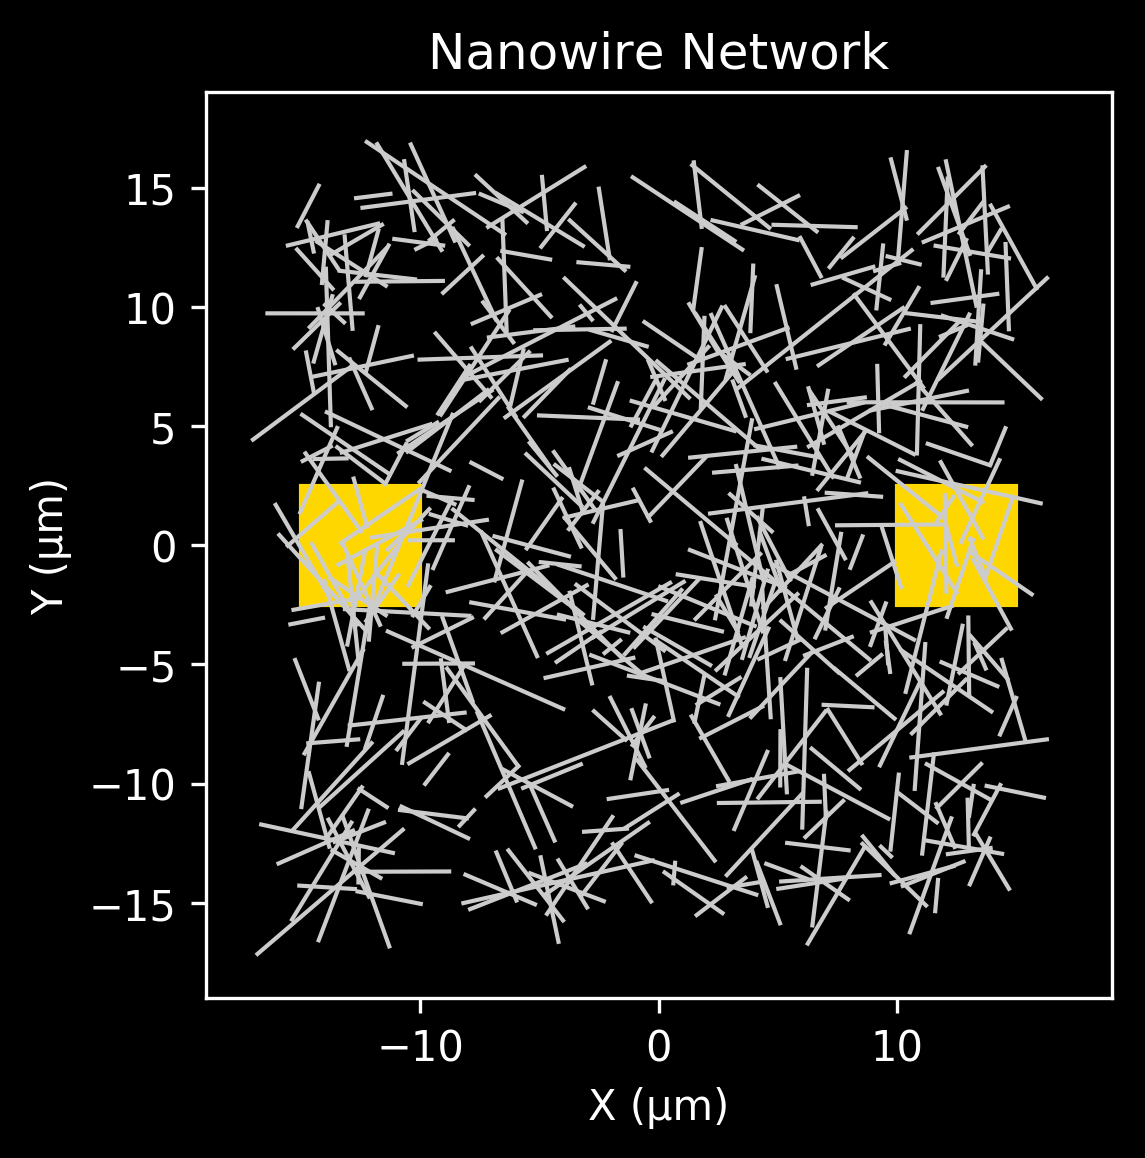

In [6]:
fig = plt.figure(dpi=300)
ax = plt.axes(xlim=(-19, 19), ylim=(-19,19))
ax.set_aspect('equal')
for nanowire in network['nanowires']:
    color = 'blue' if nanowire['connected'] else 'red'
    color = (.8,.8,.8)
    plt.plot([nanowire['start'][0], nanowire['end'][0]], [nanowire['start'][1], nanowire['end'][1]], color=color, linewidth=1)
for junction in network['junctions']:
    color = 'bo' if junction['connected'] else 'ro'
    if False:
        plt.plot([junction['position'][0]], [junction['position'][1]], color)
for electrode in network['electrodes']:
    plt.gca().add_patch(patches.Rectangle((electrode['x'], electrode['y']), electrode['w'], electrode['h'], color='gold'))
plt.xlabel("X (µm)"); plt.ylabel("Y (µm)"); plt.title('Nanowire Network');
plt.savefig('../plots/network.png', bbox_inches='tight')
plt.show()

---
# CURRENT RISE

In [7]:
def voltage_func(time, index):
    voltages = [0,.01]
    return voltages[index]
   
cc_data = simulate(params={
    'network':network,
    'ron':5e3, 'ron_sigma':0, 'roff':5e6, 'roff_sigma':0,
    'mwidth':5e-9, 'mw_sigma':0, 'initial_width':0, 'mobility':0.5e-12,
    'noise_sigma':0.1,
    'dissolution_time':1000,
    'voltage_function':voltage_func,
    'max_current':1,
    'max_current_accuracy':0.05,
    'timestep':0.1, 'total_time':200,
    'seed':0
})

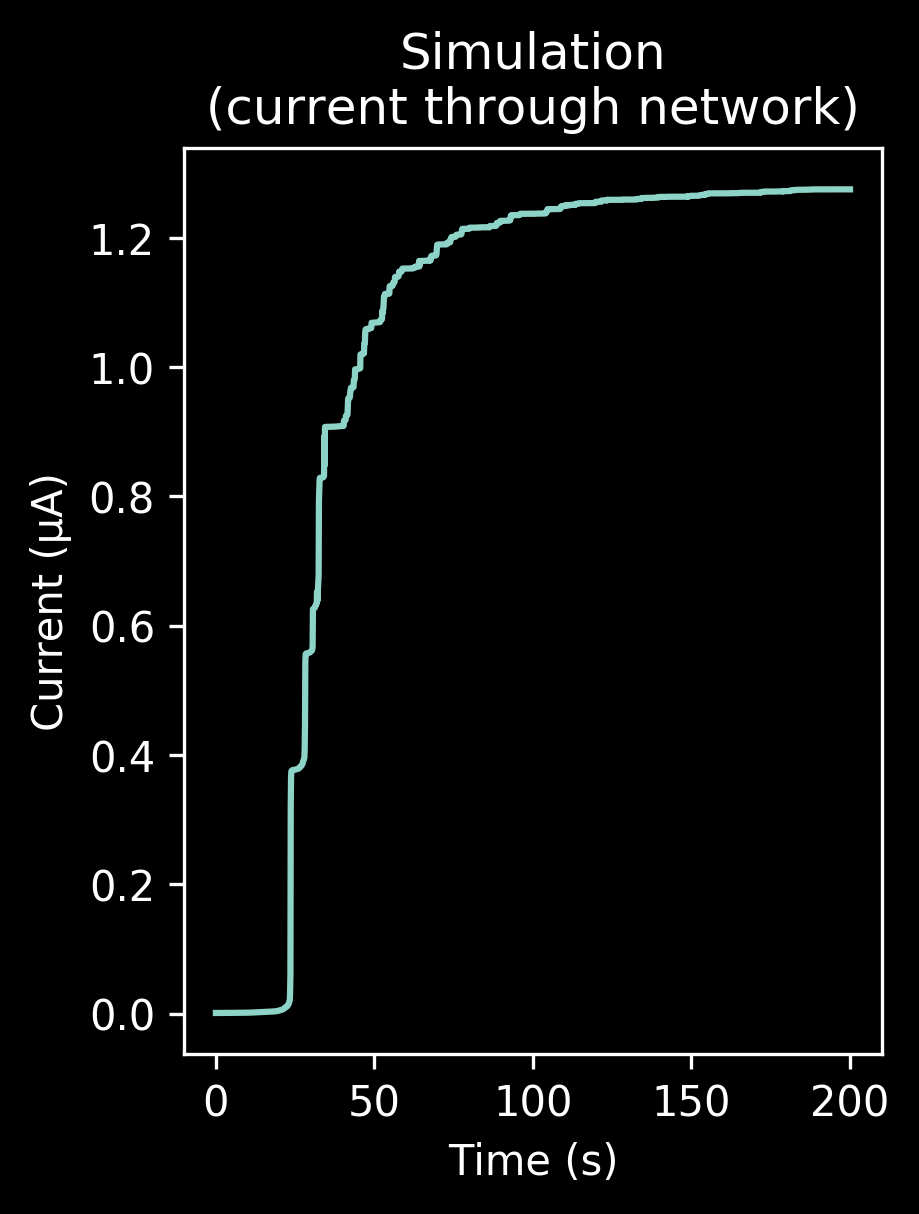

In [8]:
fig = plt.figure(figsize=(3,4), dpi=300)
#ax = plt.axes(xlim=(-19, 19), ylim=(-19,19))

times = np.array(cc_data['times'])
tcurrents = np.array(cc_data['tcurrents'])

plt.plot(times, tcurrents[:,1]*1e6);

plt.xlabel("Time (s)"); plt.ylabel("Current (µA)"); plt.title('Simulation\n(current through network)');
plt.savefig('../plots/sim_rise.png', bbox_inches='tight')
plt.show()

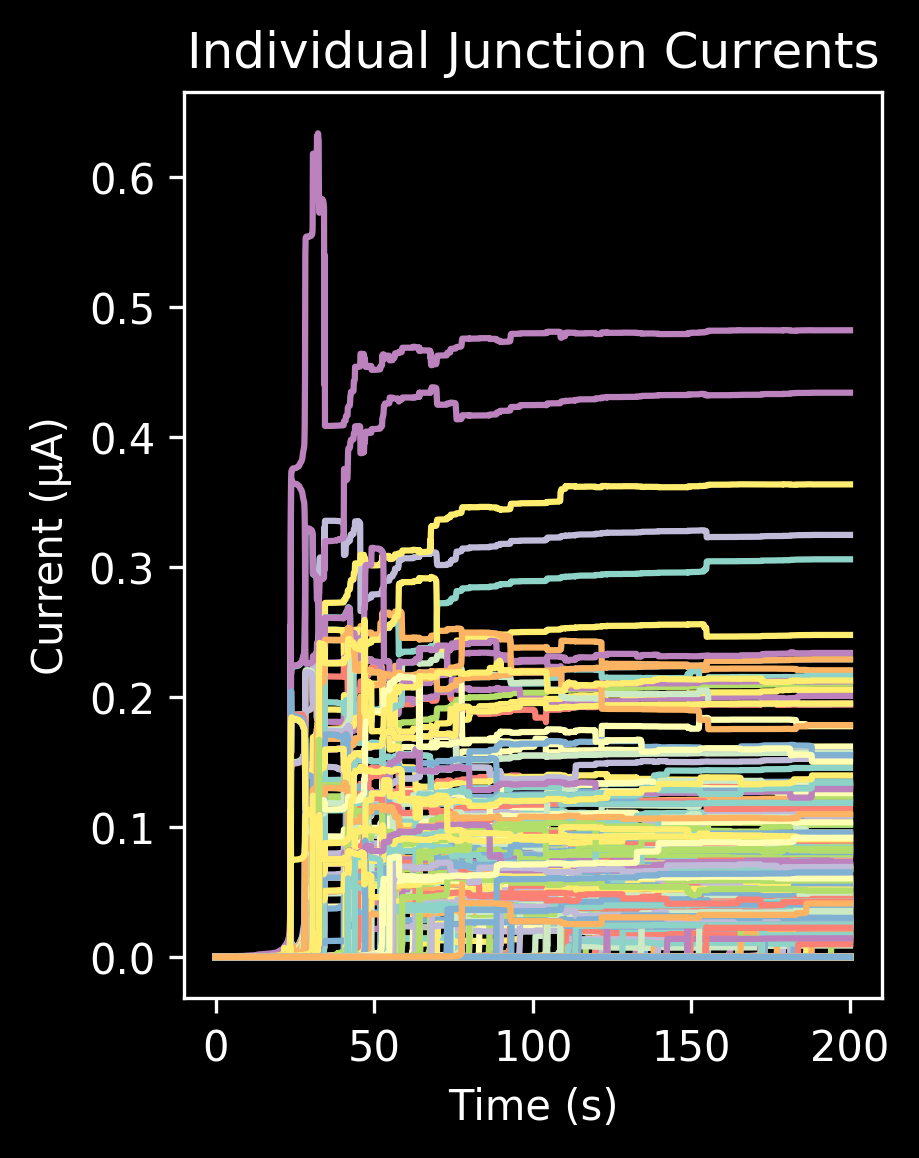

In [14]:
fig = plt.figure(figsize=(3,4), dpi=300)
#ax = plt.axes(xlim=(-19, 19), ylim=(-19,19))

times = np.array(cc_data['times'])
currents = np.abs(np.array(cc_data['currents']))

plt.plot(times, currents*1e6);

plt.xlabel("Time (s)"); plt.ylabel("Current (µA)"); plt.title('Individual Junction Currents');
plt.savefig('../plots/sim_rise_individual.png', bbox_inches='tight')
plt.show()

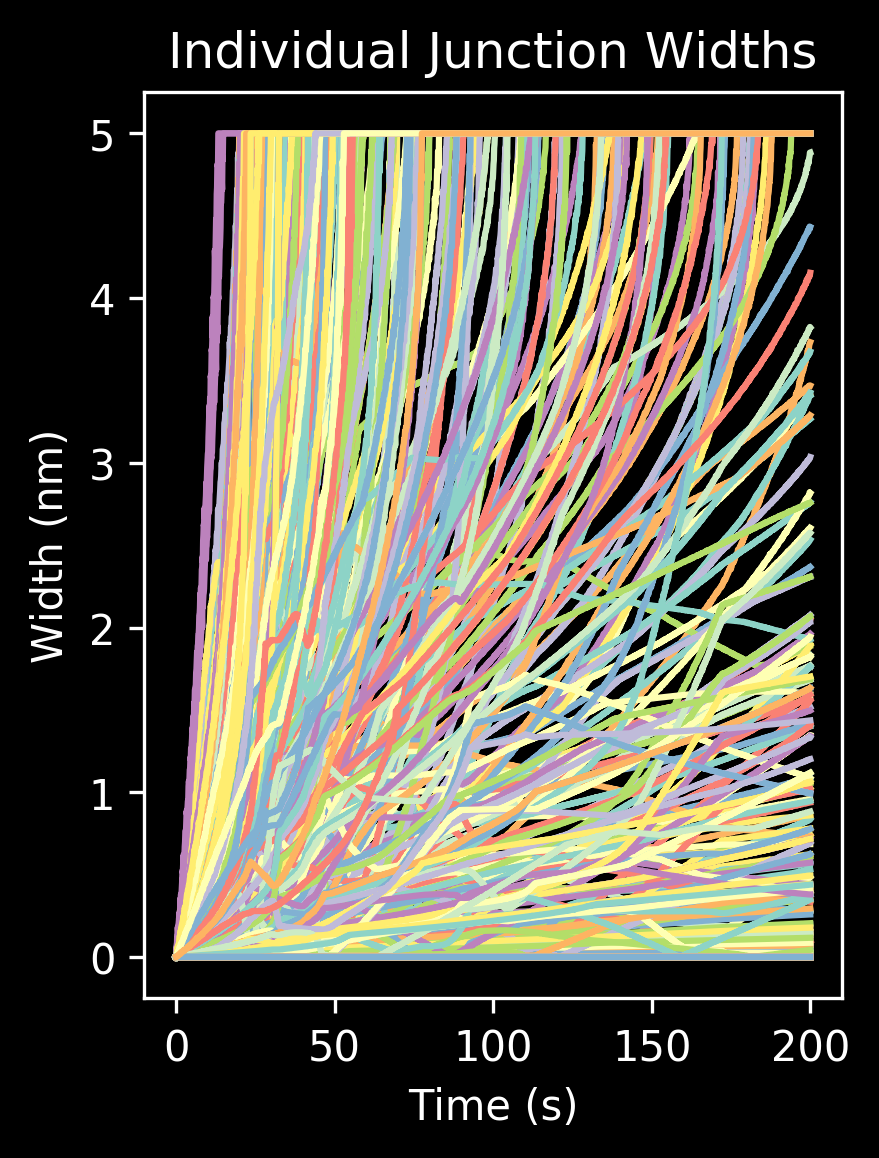

In [13]:
fig = plt.figure(figsize=(3,4), dpi=300)
#ax = plt.axes(xlim=(-19, 19), ylim=(-19,19))

times = np.array(cc_data['times'])
currents = np.abs(np.array(cc_data['widths']))

plt.plot(times, currents*1e9);

plt.xlabel("Time (s)"); plt.ylabel("Width (nm)"); plt.title('Individual Junction Widths');
plt.savefig('../plots/sim_rise_width_individual.png', bbox_inches='tight')
plt.show()

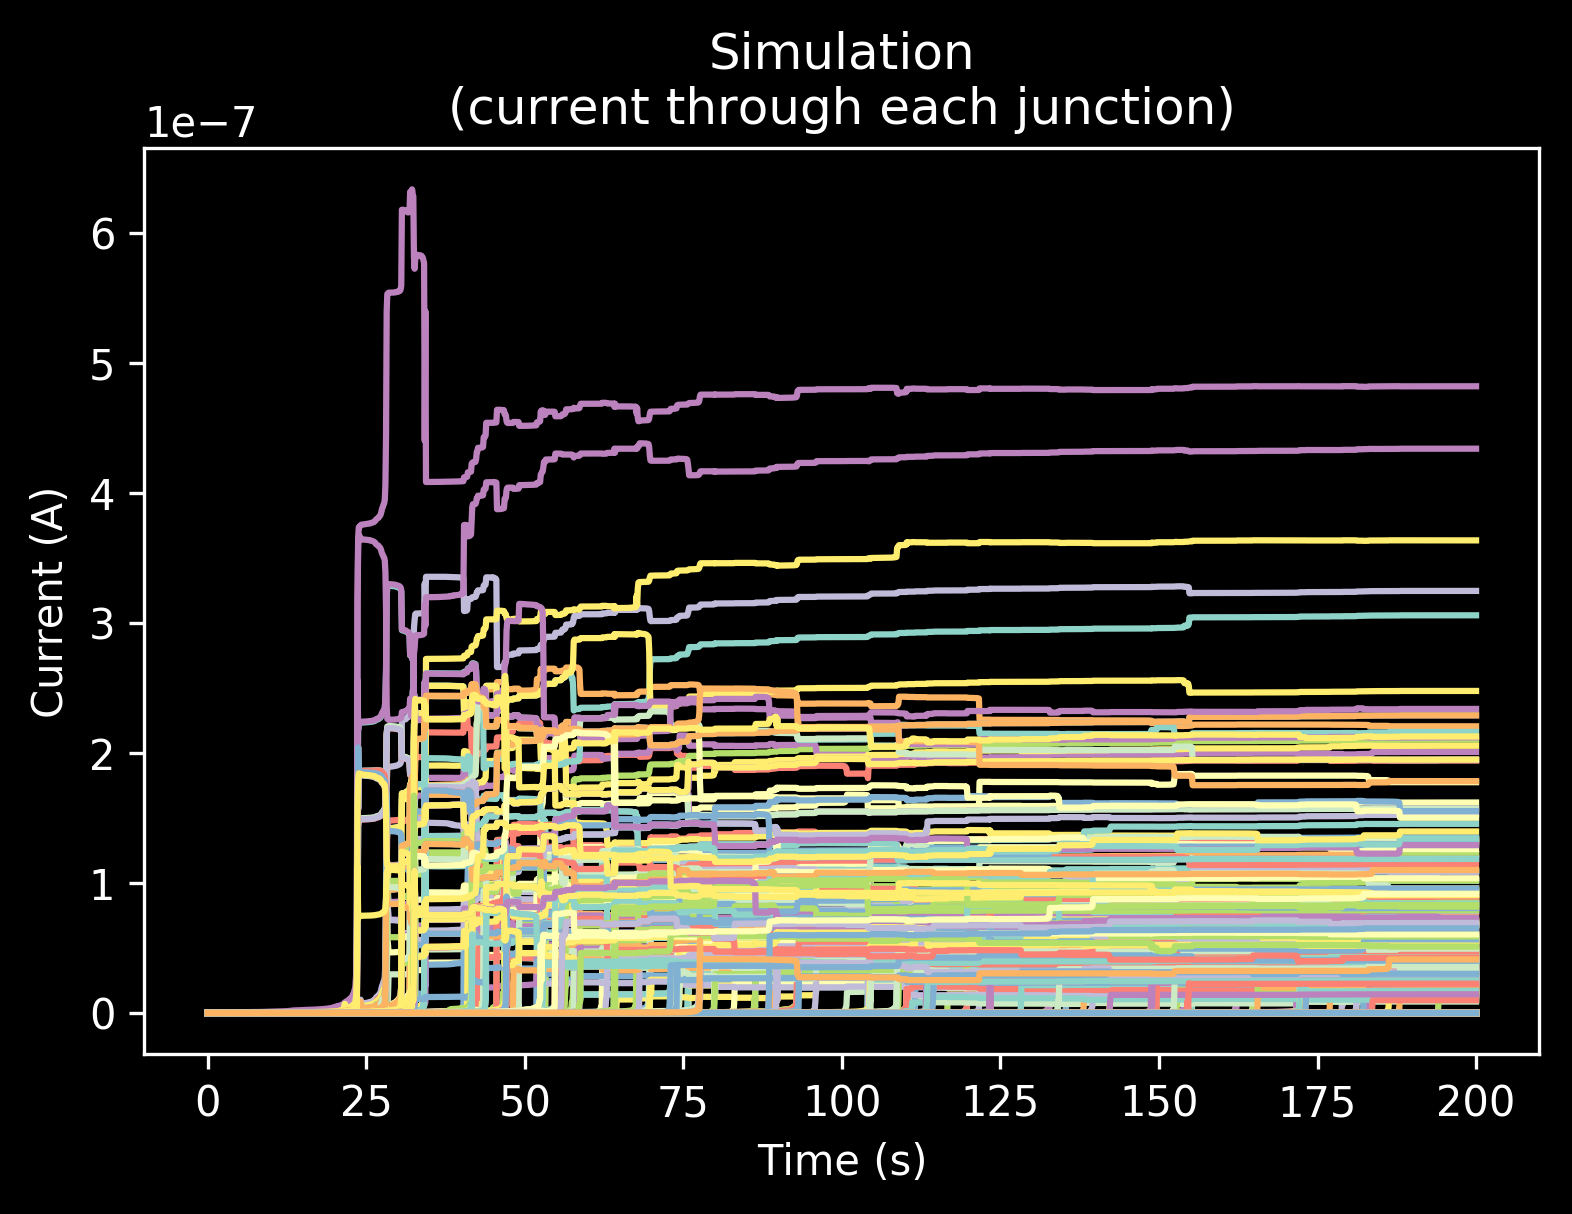

In [16]:
fig = plt.figure(dpi=300)
#ax = plt.axes(xlim=(-19, 19), ylim=(-19,19))

times = np.array(cc_data['times'])
currents = np.abs(np.array(cc_data['currents']))

plt.plot(times, currents);

plt.xlabel("Time (s)"); plt.ylabel("Current (A)"); plt.title('Simulation\n(current through each junction)');
plt.savefig('../plots/sim_rise_individual.png', bbox_inches='tight')
plt.show()

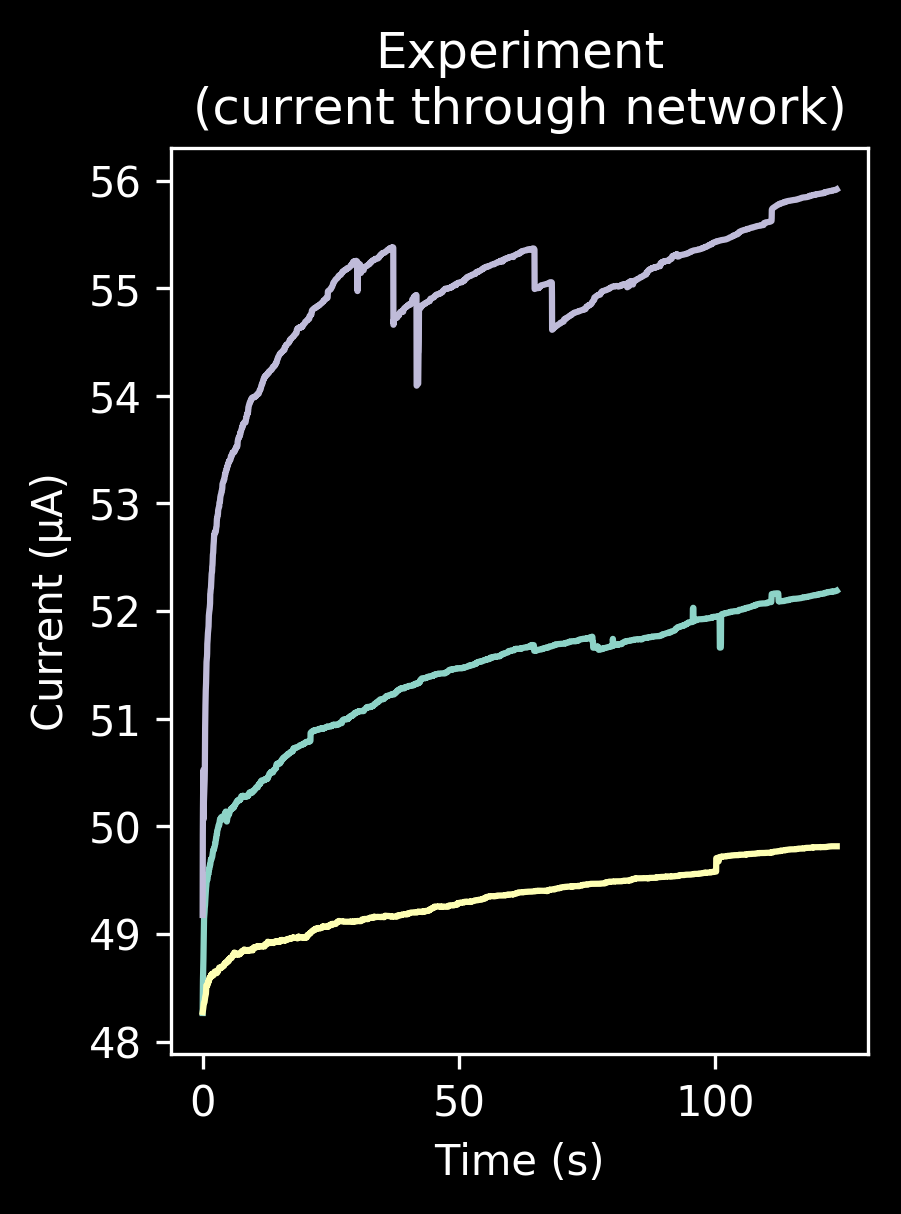

In [79]:
fig = plt.figure(figsize=(3,4), dpi=300)
#ax = plt.axes(xlim=(-19, 19), ylim=(-19,19))

for datafile in ['rise1', 'rise2', 'rise3']:
    with open('../experiment/summary/' + datafile) as data:
        times = []; currents = []
        for line in data:
            parts = line.split()
            if len(parts) == 2:
                times.append(float(parts[0])); currents.append(float(parts[1]))
        plt.plot(times, currents)

plt.xlabel("Time (s)"); plt.ylabel("Current (µA)"); plt.title('Experiment\n(current through network)');
plt.savefig('../plots/ex_rise.png', bbox_inches='tight')
plt.show()

---
# CURRENT DECAY

In [114]:
def voltage_func(time, index):
    voltages = [0,.000001]
    return voltages[index]
   
decay_data = simulate(params={
    'network':network,
    'ron':5e3, 'ron_sigma':0, 'roff':5e5, 'roff_sigma':0,
    'mwidth':5e-9, 'mw_sigma':0, 'initial_width':1, 'mobility':0.5e-12,
    'noise_sigma':0.1,
    'dissolution_time':10000000,
    'voltage_function':voltage_func,
    'max_current':1,
    'max_current_accuracy':0.05,
    'timestep':0.1, 'total_time':100,
    'seed':0
})

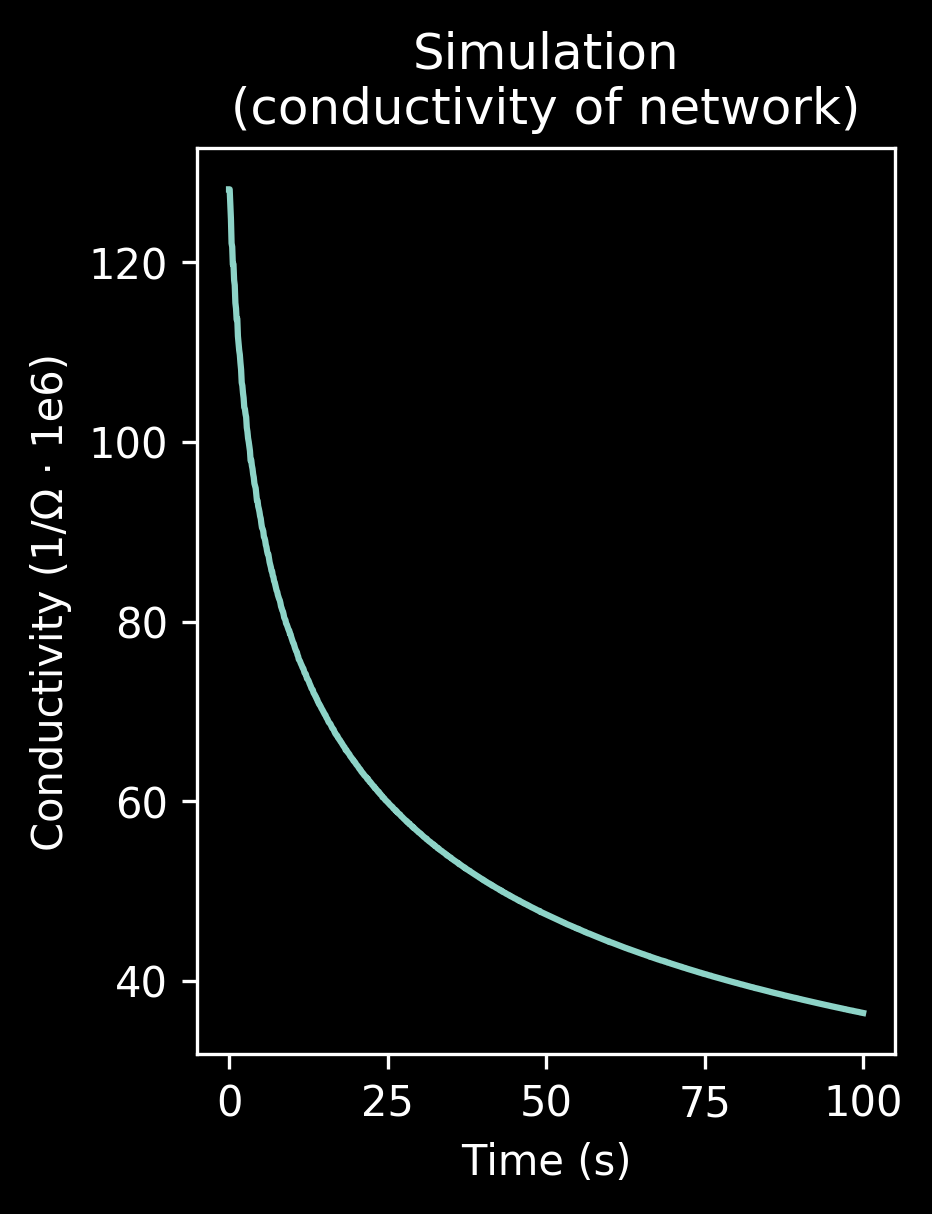

In [115]:
fig = plt.figure(figsize=(3,4), dpi=300)
#ax = plt.axes(xlim=(-19, 19), ylim=(-19,19))

times = np.array(decay_data['times'])
tcurrents = (np.array(decay_data['tcurrents'])/1e6)/.000001*1e6 # convert from uA to 1/R

plt.plot(times, tcurrents[:,1]*1e6);

plt.xlabel("Time (s)"); plt.ylabel("Conductivity (1/Ω · 1e6)"); plt.title('Simulation\n(conductivity of network)');
plt.savefig('../plots/sim_decay.png', bbox_inches='tight')
plt.show()

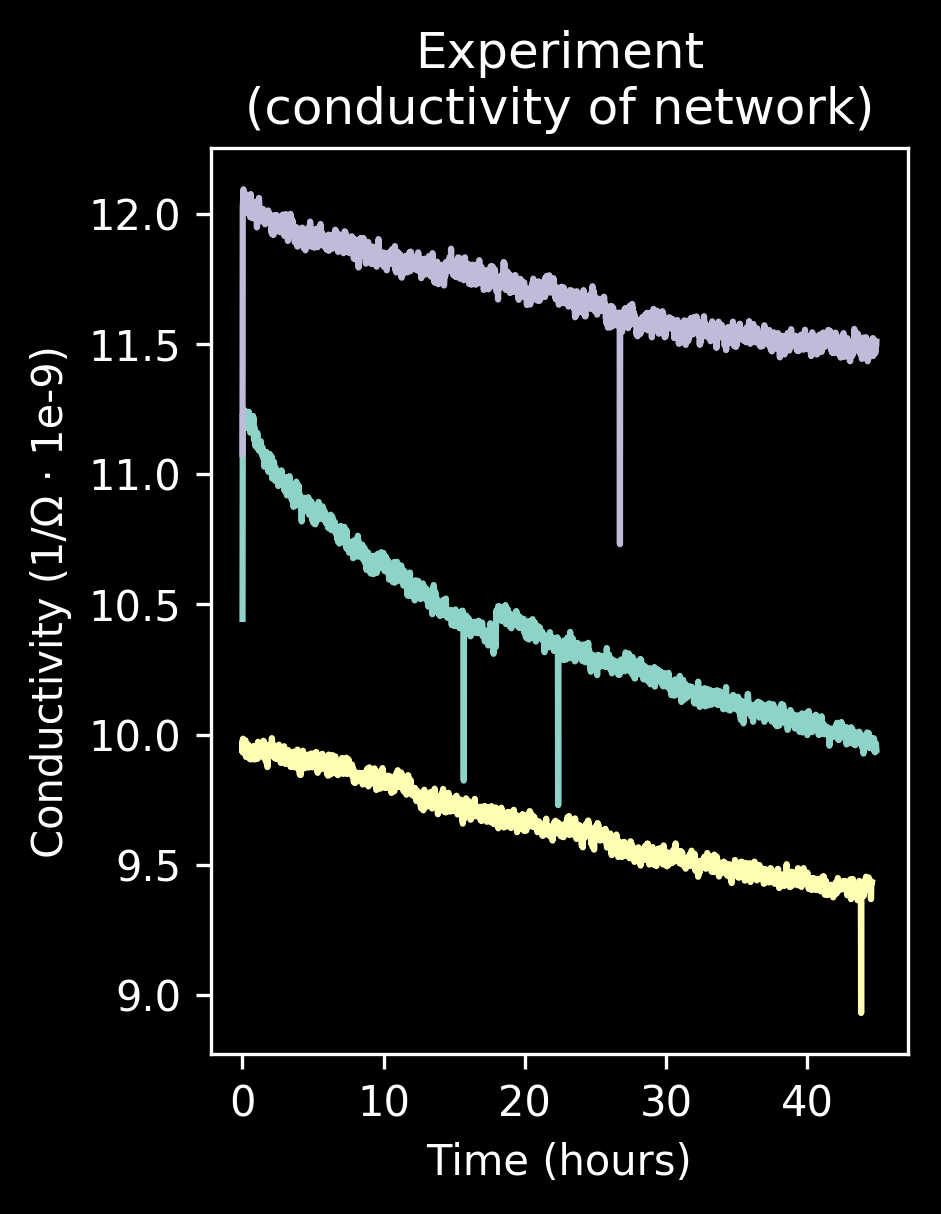

In [120]:
fig = plt.figure(figsize=(3,4), dpi=300)
#ax = plt.axes(xlim=(-19, 19), ylim=(-19,19))

for datafile in ['decay1', 'decay2']:
    with open('../experiment/summary/' + datafile) as data:
        times = []; currents = []
        for line in data:
            parts = line.split()
            if len(parts) == 2:
                times.append(float(parts[0])); currents.append(float(parts[1]))
        currents = np.array(currents)*1e6/1e-3*1e-9 # convert from uA to 1/R
        if datafile == 'decay1':
            plt.plot(times[:2700], currents[:2700])
            plt.plot(np.array(times[2700:])-times[2700], currents[2700:])
        else:
            plt.plot(times[:2700], currents[:2700])

plt.xlabel("Time (hours)"); plt.ylabel("Conductivity (1/Ω · 1e-9)"); plt.title('Experiment\n(conductivity of network)');
plt.savefig('../plots/ex_decay.png', bbox_inches='tight')
plt.show()

---
# PARAMETER SWEEP

In [70]:
def freq_voltage_func(frequency):
    return lambda time, index:  [0,.1*math.sin(2*math.pi*time*frequency)][index]

def simulate_time(frequency):
    data = simulate(params={
        'network':network,
        'ron':5e3, 'ron_sigma':0, 'roff':5e6, 'roff_sigma':0,
        'mwidth':5e-9, 'mw_sigma':0, 'initial_width':0, 'mobility':0.5e-12,
        'noise_sigma':0.1,
        'dissolution_time':3,
        'voltage_function':freq_voltage_func(frequency),
        'max_current':1,
        'max_current_accuracy':0.05,
        'timestep':0.01, 'total_time':20,
        'seed':0
    })
    # cannot return data directly for some arcane reason
    return {'times':data['times'], 'currents':data['currents'],
            'widths':data['widths'], 'voltages':data['voltages'],
            'conductivities':data['conductivities'],
            'tcurrents':data['tcurrents'], 'freq':frequency}

wrenexec = pywren.default_executor()
futures = wrenexec.map(simulate_time, np.linspace(.03, 1, 10))
amazon_data = pywren.get_all_results(futures)

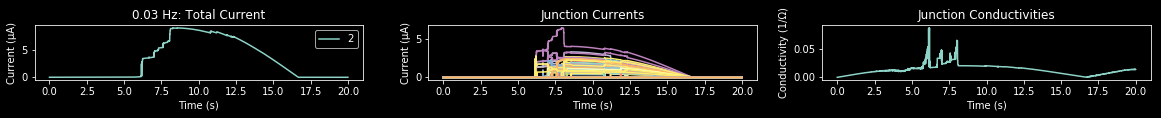

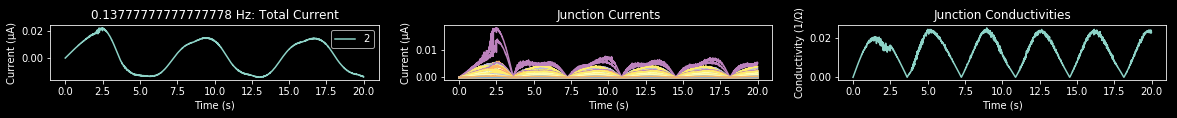

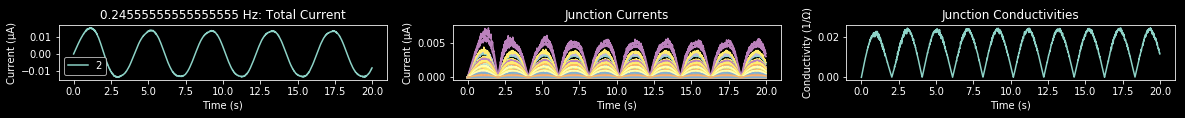

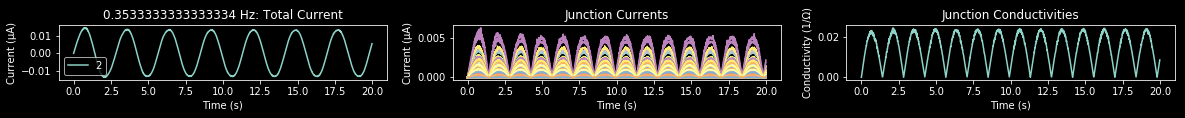

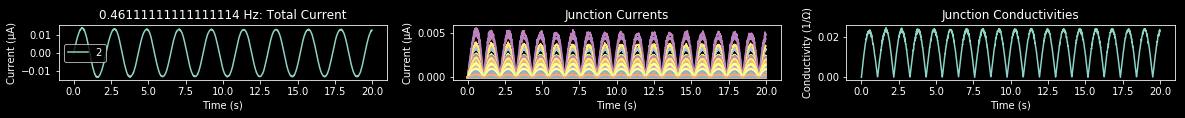

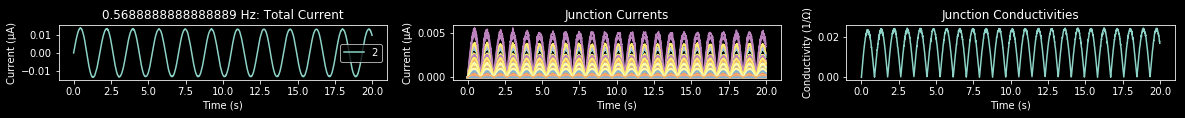

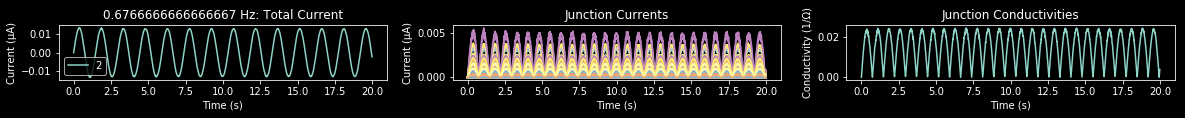

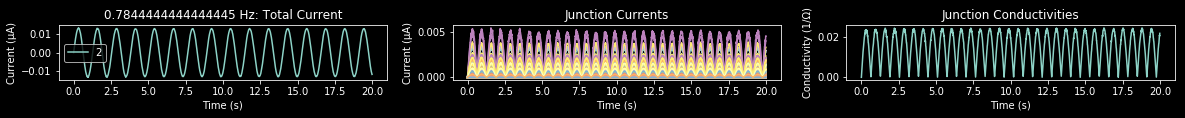

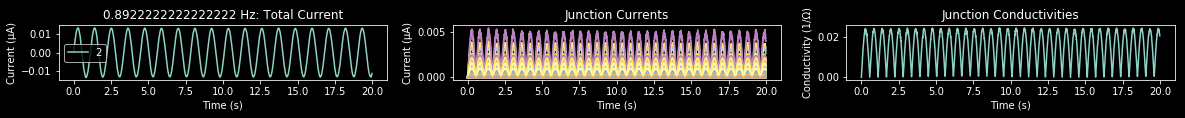

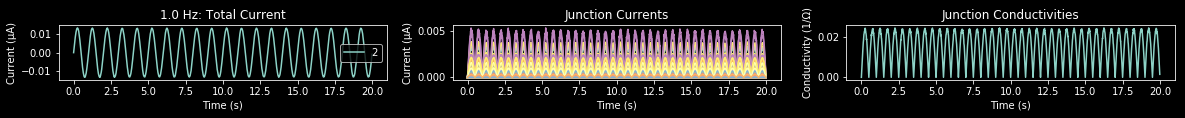

In [121]:
for idx, data in enumerate(amazon_data):
    times = np.array(data['times'])
    currents = np.abs(np.array(data['currents']))
    widths = np.abs(np.array(data['widths']))
    voltages = np.array(data['voltages'])
    conductivities = np.array(data['conductivities'])
    tcurrents = np.array(data['tcurrents'])
    frequency = data['freq']
    
    def plotfft(data, timestep, title):
        freqpoints = np.linspace(0, 1/(2*timestep), math.ceil(len(data)/2))
        fft = (np.abs(np.fft.fft(data))**2)[0:len(freqpoints)]
        plt.loglog(freqpoints, fft);
        plt.xlabel('Frequency (Hz)'); plt.ylabel('Intensity'); plt.title(title); plt.show()
   
    maxvoltages = np.abs(currents / conductivities).max(axis=1)
    
    cutoff = 0 
    plt.figure(figsize=(20,1))
    plt.subplot(131)
    plt.plot(times[cutoff:], tcurrents[cutoff:,1]*1e6, label='2'); plt.legend(); plt.title('{} Hz: Total Current'.format(frequency)); plt.xlabel('Time (s)'); plt.ylabel('Current (µA)');
    plt.subplot(132)
    plt.plot(times, currents*1e6); plt.title('Junction Currents'); plt.xlabel('Time (s)'); plt.ylabel('Current (µA)');
    plt.subplot(133)
    plt.plot(times, maxvoltages); plt.title('Junction Conductivities'); plt.xlabel('Time (s)'); plt.ylabel('Conductivity (1/Ω)');
    plt.savefig('../plots/sweep_{}.png'.format(idx), bbox_inches='tight')
    plt.show()

In [4]:
def voltage_func():
    return lambda time, index:  [0,.1][index]

def simulate_time(dissolution_time):
    data = simulate(params={
        'network':network,
        'ron':5e3, 'ron_sigma':0, 'roff':5e6, 'roff_sigma':0,
        'mwidth':5e-9, 'mw_sigma':0, 'initial_width':0, 'mobility':0.5e-12,
        'noise_sigma':0.1,
        'dissolution_time':dissolution_time,
        'voltage_function':voltage_func(),
        'max_current':1,
        'max_current_accuracy':0.05,
        'timestep':0.01, 'total_time':30,
        'seed':0
    })
    # cannot return data directly for some arcane reason
    return {'times':data['times'], 'currents':data['currents'],
            'widths':data['widths'], 'voltages':data['voltages'],
            'conductivities':data['conductivities'],
            'tcurrents':data['tcurrents'], 'dtime':dissolution_time}

wrenexec = pywren.default_executor()
futures = wrenexec.map(simulate_time, np.linspace(.1, 5, 20))
amazon_data_linear = pywren.get_all_results(futures)

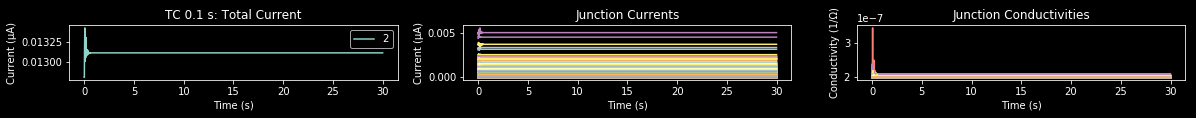

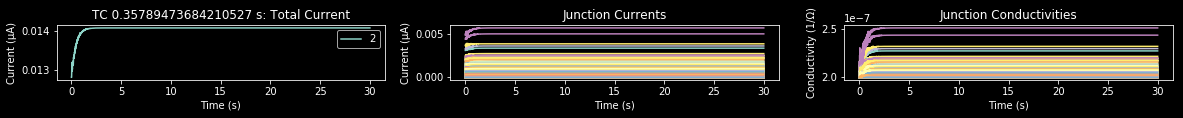

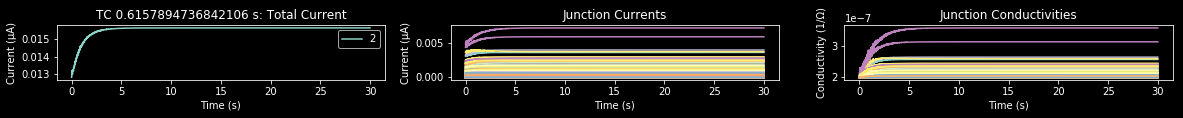

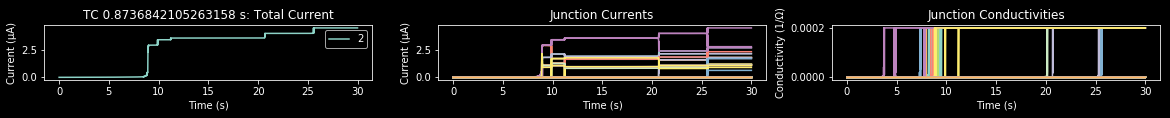

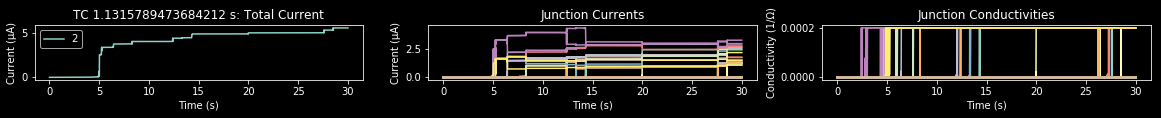

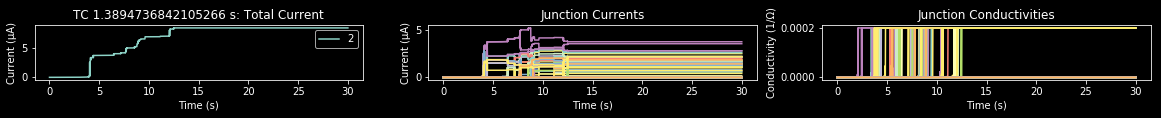

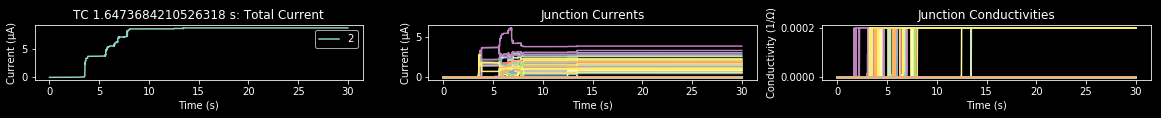

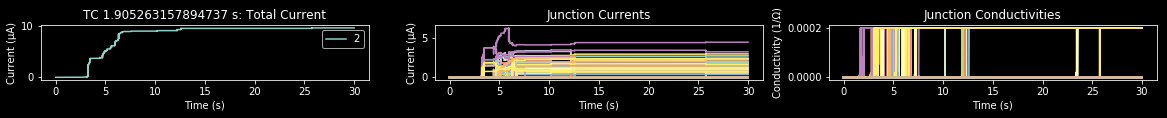

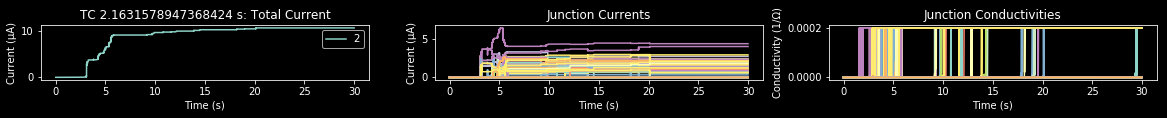

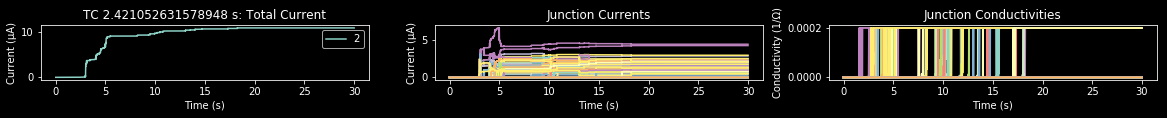

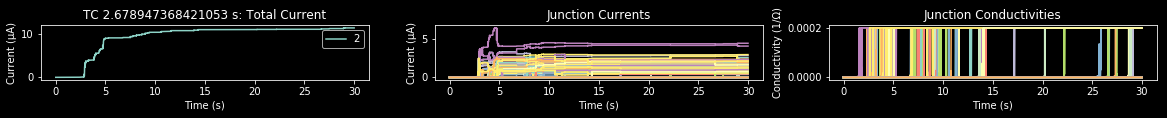

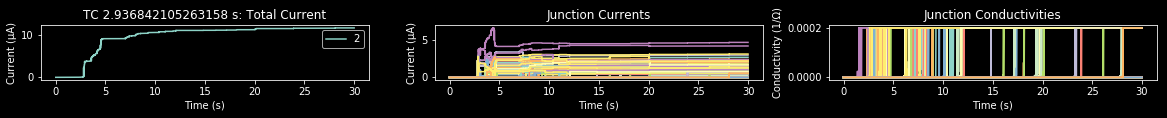

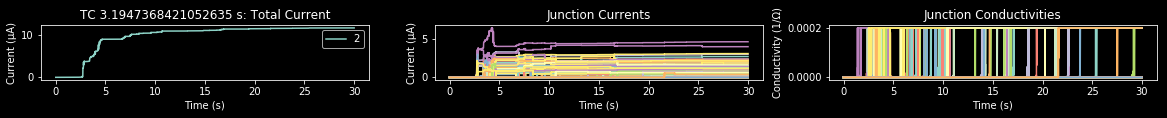

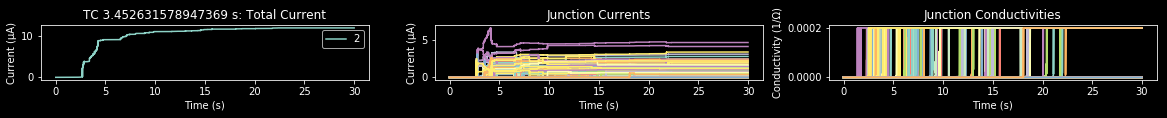

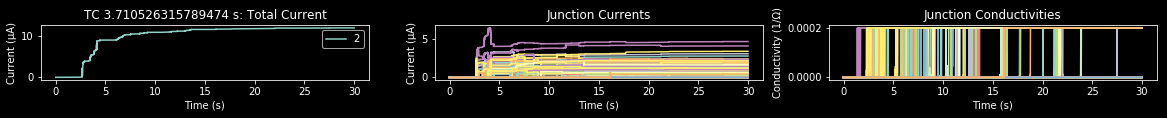

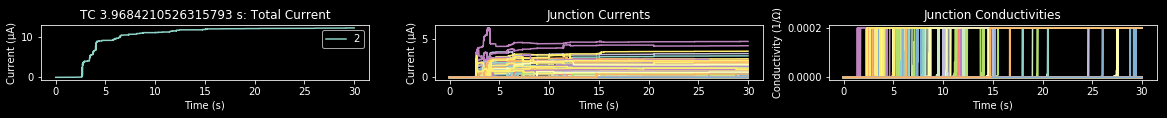

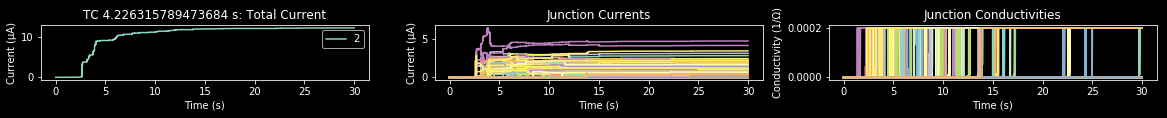

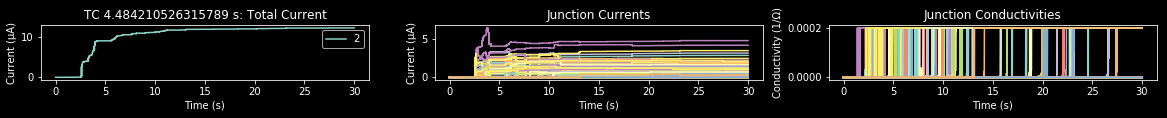

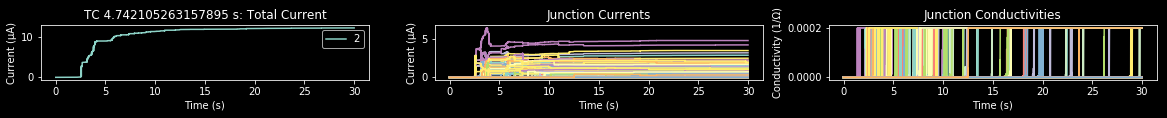

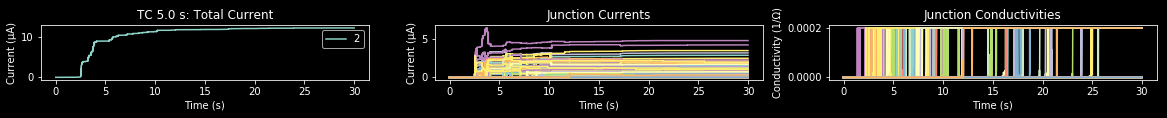

In [9]:
for idx, data in enumerate(amazon_data_linear):
    times = np.array(data['times'])
    currents = np.abs(np.array(data['currents']))
    widths = np.abs(np.array(data['widths']))
    voltages = np.array(data['voltages'])
    conductivities = np.abs(np.array(data['conductivities']))
    tcurrents = np.array(data['tcurrents'])
    dtime = data['dtime']
    
    def plotfft(data, timestep, title):
        freqpoints = np.linspace(0, 1/(2*timestep), math.ceil(len(data)/2))
        fft = (np.abs(np.fft.fft(data))**2)[0:len(freqpoints)]
        plt.loglog(freqpoints, fft);
        plt.xlabel('Frequency (Hz)'); plt.ylabel('Intensity'); plt.title(title); plt.show()
   
    #maxvoltages = np.abs(currents / conductivities).max(axis=1)
    
    cutoff = 0 
    plt.figure(figsize=(20,1))
    plt.subplot(131)
    plt.plot(times[cutoff:], tcurrents[cutoff:,1]*1e6, label='2'); plt.legend(); plt.title('TC {} s: Total Current'.format(dtime)); plt.xlabel('Time (s)'); plt.ylabel('Current (µA)');
    plt.subplot(132)
    plt.plot(times, currents*1e6); plt.title('Junction Currents'); plt.xlabel('Time (s)'); plt.ylabel('Current (µA)');
    plt.subplot(133)
    plt.plot(times, conductivities); plt.title('Junction Conductivities'); plt.xlabel('Time (s)'); plt.ylabel('Conductivity (1/Ω)');
    plt.savefig('../plots/sweep_linear_{}.png'.format(idx), bbox_inches='tight')
    plt.show()

---
# SIMPLE RISE ANIMATION

Simulating network...
Voronoifying network...
Drawing voronoi...
Finishing...


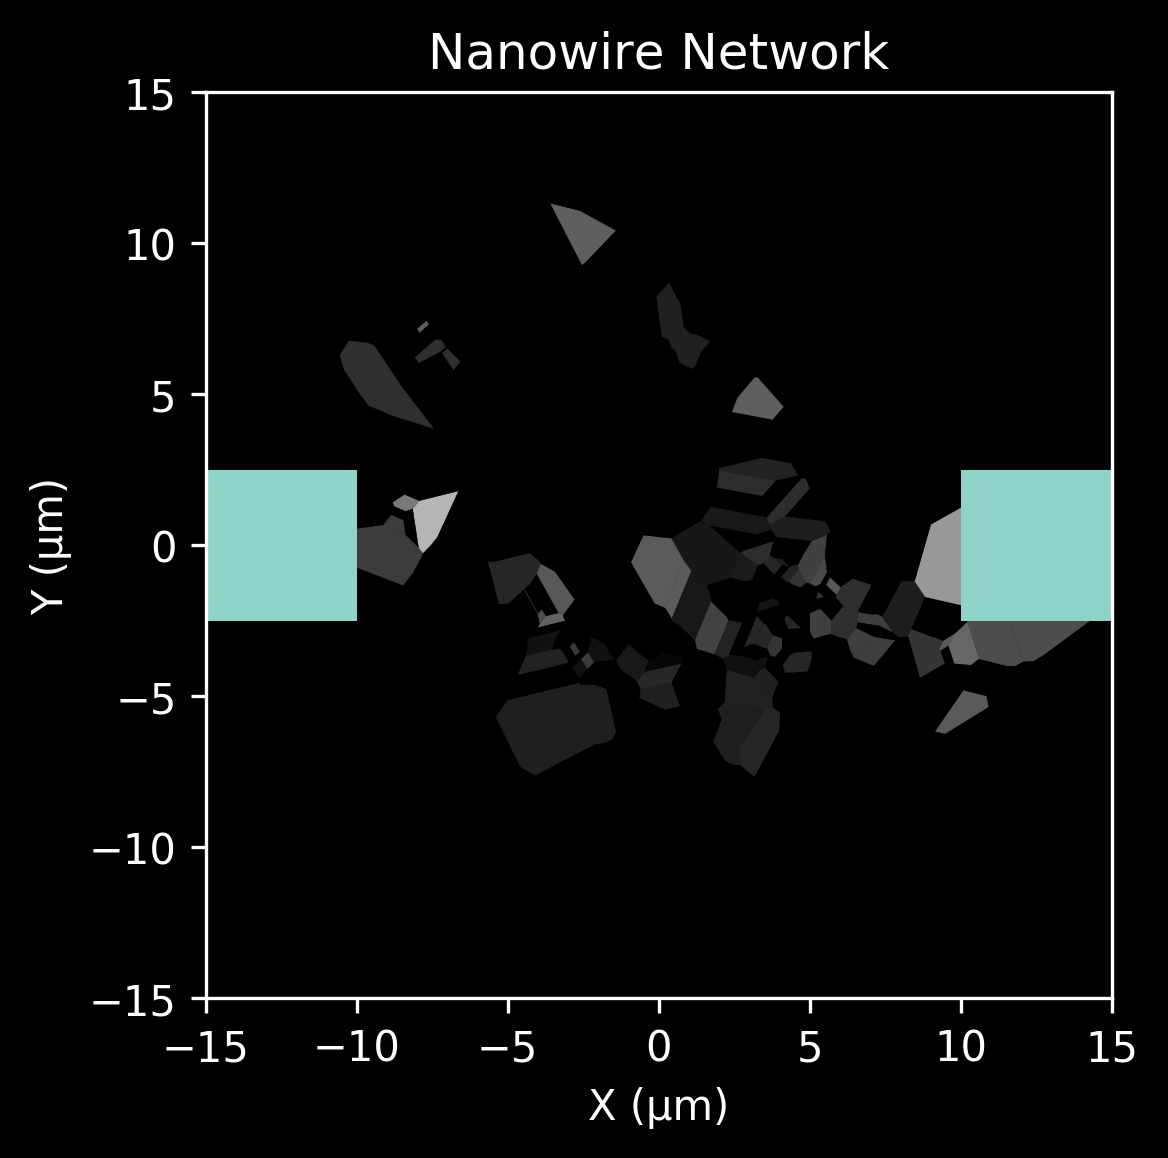

In [127]:
print('Simulating network...')

def voltage_func(time, index):
    voltages = [0.1,0,0]
    return voltages[index]

anim_data = simulate(params={
    'network':network,
    'ron':5e3, 'ron_sigma':0, 'roff':5e6, 'roff_sigma':0,
    'mwidth':5e-9, 'mw_sigma':0, 'initial_width':0, 'mobility':0.5e-12,
    'noise_sigma':0.1,
    'dissolution_time':10,
    'voltage_function':voltage_func,
    'max_current':1e-4,
    'max_current_accuracy':0.05,
    'timestep':0.01, 'total_time':5,
    'seed':0
})

print('Voronoifying network...')

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    From https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram
    
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def polyarea(x,y):
    # from https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates#30408825
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

points = np.array([j['position'] for j in network['junctions']])
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor, radius=None)
polygons = np.array([np.array([vertices[i] for i in region]) for region in regions]) # list of lists of points
edgepairs = [[polygons[i][:,0], polygons[i][:,1]] for i in range(len(polygons))]
areas = np.array([polyarea(edgepairs[i][0], edgepairs[i][1]) for i in range(len(edgepairs))])
currents = np.abs(anim_data['currents'])

print('Drawing voronoi...')
fig = plt.figure(dpi=300)
ax = plt.axes(xlim=(-15, 15), ylim=(-15, 15))
ax.set_aspect('equal')

jpatches = []
for i, point in enumerate(points):
    color = currents[-1][i]/np.max(currents)
    jpatch = patches.Polygon(polygons[i], color=(1-color,1-color,1-color))
    jpatch.set_linewidth(.1)
    jpatches.append(jpatch)
    ax.add_patch(jpatch)
print('Finishing...')
for electrode in network['electrodes']:
    ax.add_patch(patches.Rectangle((electrode['x'], electrode['y']), electrode['w'], electrode['h']))
    
def init():
    return jpatches
def animate(time):
    for i, jpatch in enumerate(jpatches):
        color = currents[time][i]/np.max(currents)
        jpatch.set_color((color,color,color))
    return jpatches
ax.set_xlabel("X (µm)")
ax.set_ylabel("Y (µm)")
ax.set_title('Nanowire Network');
anim = animation.FuncAnimation(fig, animate,
        init_func=init, frames=500, interval=20, blit=True)
anim.save('../plots/animation_rise.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()

---
# SWITCH ANIMATION

In [24]:
switch_network = create_network(params={
    'width':5, 'height':50,
    'inputs':2, 'outputs':1,
    'e_width':5, 'e_height':5,
    'density':.5,
    'lalpha':6, 'lloc':0, 'lbeta':1,
    'seed':1
})


print('Simulating network...')

def voltage_func(time, index):
    voltages = [0,0,0]
    if time < 2:
        voltages = [0,1,1]
    elif time < 4:
        voltages = [0,0,1]
    elif time < 6:
        voltages = [1,0,1]
    else:
        voltages = [0,0,1]
    return voltages[index]
   
switch_data = simulate(params={
    'network':switch_network,
    'ron':5e3, 'ron_sigma':0, 'roff':5e6, 'roff_sigma':0,
    'mwidth':5e-9, 'mw_sigma':0, 'initial_width':0, 'mobility':0.5e-12,
    'noise_sigma':0.1,
    'dissolution_time':.1,
    'voltage_function':voltage_func,
    'max_current':.00001,#.0000003,#.00006,
    'max_current_accuracy':0.05,
    'timestep':0.01, 'total_time':8,
    'seed':0
})

Simulating network...
Voronoifying network...
Drawing voronoi...


IndexError: index 741 is out of bounds for axis 0 with size 741

Voronoifying network...
Drawing voronoi...
Finishing...


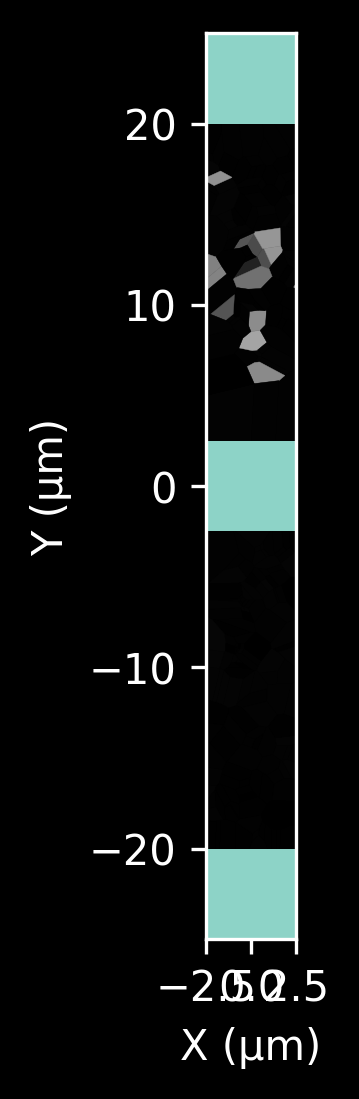

In [28]:
print('Voronoifying network...')

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    From https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram
    
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def polyarea(x,y):
    # from https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates#30408825
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

points = np.array([j['position'] for j in switch_network['junctions']])
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor, radius=None)
polygons = np.array([np.array([vertices[i] for i in region]) for region in regions]) # list of lists of points
edgepairs = [[polygons[i][:,0], polygons[i][:,1]] for i in range(len(polygons))]
areas = np.array([polyarea(edgepairs[i][0], edgepairs[i][1]) for i in range(len(edgepairs))])
currents = np.abs(switch_data['currents'])

print('Drawing voronoi...')
fig = plt.figure(dpi=300)
ax = plt.axes(xlim=(-2.5, 2.5), ylim=(-25, 25))
ax.set_aspect('equal')

jpatches = []
for i, point in enumerate(points):
    color = currents[-1][i]/np.max(currents)
    jpatch = patches.Polygon(polygons[i], color=(1-color,1-color,1-color))
    jpatch.set_linewidth(.1)
    jpatches.append(jpatch)
    ax.add_patch(jpatch)
print('Finishing...')
for electrode in switch_network['electrodes']:
    ax.add_patch(patches.Rectangle((electrode['x'], electrode['y']), electrode['w'], electrode['h']))
    
def init():
    return jpatches
def animate(time):
    for i, jpatch in enumerate(jpatches):
        color = np.sqrt(currents[time][i]/np.max(currents))
        jpatch.set_color((color,color,color))
    return jpatches
ax.set_xlabel("X (µm)")
ax.set_ylabel("Y (µm)")
anim = animation.FuncAnimation(fig, animate,
        init_func=init, frames=800, interval=20, blit=True)
anim.save('../plots/switch.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()

Creating network...
Simulating network...
Voronoifying network...
Drawing voronoi...
Finishing...


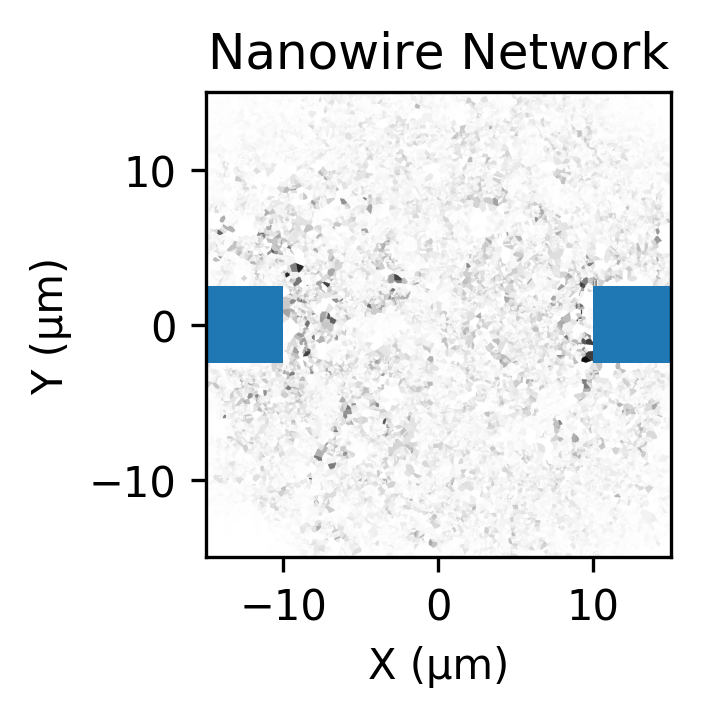

In [278]:
print('Creating network...')

network = create_network(params={
    'width':30, 'height':30,
    'inputs':1, 'outputs':1,
    'e_width':5, 'e_height':5,
    'density':15, # for about 250 nanowires total
    'lalpha':4, 'lloc':0, 'lbeta':0.2,
    #'lalpha':5.77, 'lloc':-0.65, 'lbeta':0.88,
    'seed':0
})

print('Simulating network...')

def voltage_func(time, index):
    voltages = [10,0,0]
    return voltages[index]
   
# use random number in data variable so it isn't written over by other simulations
data = simulate(params={
    'network':network,
    'ron':5e3, 'ron_sigma':0, 'roff':5e6, 'roff_sigma':0,
    'mwidth':5e-9, 'mw_sigma':0, 'initial_width':0, 'mobility':0.5e-12,
    'noise_sigma':0.1,
    'dissolution_time':10,
    'voltage_function':voltage_func,
    'max_current':1e-4,
    'max_current_accuracy':0.05,
    'timestep':0.01, 'total_time':.01,
    'seed':0
})

print('Voronoifying network...')


def voronoi_finite_polygons_2d(vor, radius=None):
    """
    From https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram
    
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def polyarea(x,y):
    # from https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates#30408825
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

points = np.array([j['position'] for j in network['junctions']])
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor, radius=None)
polygons = np.array([np.array([vertices[i] for i in region]) for region in regions]) # list of lists of points
edgepairs = [[polygons[i][:,0], polygons[i][:,1]] for i in range(len(polygons))]
areas = np.array([polyarea(edgepairs[i][0], edgepairs[i][1]) for i in range(len(edgepairs))])
currents = np.abs(data['currents'])

print('Drawing voronoi...')
fig = plt.figure(figsize=(2,4),dpi=300)
ax = plt.axes(xlim=(-15, 15), ylim=(-15, 15))
ax.set_aspect('equal')

jpatches = []
for i, point in enumerate(points):
    color = currents[-1][i]/np.max(currents)
    jpatch = patches.Polygon(polygons[i], color=(1-color,1-color,1-color))
    jpatch.set_linewidth(.1)
    jpatches.append(jpatch)
    ax.add_patch(jpatch)
print('Finishing...')
for electrode in network['electrodes']:
    ax.add_patch(patches.Rectangle((electrode['x'], electrode['y']), electrode['w'], electrode['h']))
    
def init():
    return jpatches
def animate(time):
    for i, jpatch in enumerate(jpatches):
        color = currents[time][i]/np.max(currents)
        jpatch.set_color((color,color,color))
    return jpatches
ax.set_xlabel("X (µm)")
ax.set_ylabel("Y (µm)")
ax.set_title('Nanowire Network');
anim = animation.FuncAnimation(fig, animate,
        init_func=init, frames=500, interval=20, blit=True)
#anim.save('network3.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()